In [1]:
import os
# Отключает все логи TensorFlow (0 - все, 1 - предупреждения, 2 - ошибки, 3 - критичные ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [97]:
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import time  
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, confusion_matrix, accuracy_score, f1_score, r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
import xgboost as xgb

# Создадим класс для рабты с данными

In [8]:
class Car:

    """
    Класс для работы с датафреймом.
    Параметры:
    self.df  - датафрейм
    Методы:
    unique_count(self) - метод посчета уникальных данных в столбцах
    correlation_number(self) - метод для вычисления корреляционной матрицы по числовым столбцам.
    correlation_category(self) - метод для вычисления корреляционной матрицы по категорийным столбцам
    heatmap(self, first_col: str, second_col: str, main_col: str ) - метод построения графика корр. матрицы
    my_graf(self, first_col, second_col, data_df=None) - метод построения графиков
    remove_outliers_STD(self, numerical_columns) - метод для фильтрации выбросов (стандартное отклонение)
    remove_outliers_IQR(self, numerical_columns) - метод для фильтрации выбросов (квантили)
    """
    def __init__(self, path):
        self.df = pd.read_csv(path)

    def summary_statistics(self, first_col: str, second_col: str, **kwargs) -> pd.DataFrame:
       
        """
        Метод для вычисления статистики по second_col, сгруппированную по first_col.
        Параметры:
        first_col - первый столбец (используется для группировки)
        second_col - второй стобец - для посчета статистики
        **kwargs - словари для фильтрации (выполняются в первую очередь)
        Возвращает:
        pd.DataFrame - статистика по сгруппированным столбцам
        """
        
        df: pd.DataFrame = self.df  # Работаем с копией DataFrame
        
        # Применяем все фильтры, если они есть
        for filter_col, filter_value in kwargs.items():
            if filter_col == 'Cabin':
                # Фильтруем по первой букве в значении столбца 'Cabin'
                df = df[df[filter_col].str[0] == filter_value]
            else:
                # Фильтруем по обычному значению
                df = df[df[filter_col] == filter_value]
        
        # Возвращаем статистику по данным
        return df[[first_col, second_col]].groupby(first_col, observed=False).describe()

    def unique_count(self):
        
        """
        Метод посчета уникальных данных в столбцах и вывода их списком (если они не числа)
        """
    
        for col in self.df.columns:
            unique_count: int = self.df[col].nunique()  # Количество уникальных значений для каждого столбца
            unique_values: List[Union(int|str)] = self.df[col].unique().tolist()  # Список уникальных значений для каждого столбца
            
            # Проверяем, все ли значения можно преобразовать в числа (чтобы отсеять числовые поля)
            is_numeric: bool = pd.to_numeric(self.df[col], errors='coerce').notnull().all()
            
            if is_numeric:
                print(f"Столбец '{col}': уникальных значений {unique_count} — цифровые значения")
            else:
                print(f"Столбец '{col}': уникальных значений {unique_count} — {unique_values[:5]}")

    def correlation_number(self) -> pd.DataFrame:
        
        """
        Метод для вычисления корреляционной матрицы по числовым столбцам.
        Возвращает:
        correlation_matrix - корреляционную матрицу
        """
        
        columns_list: List[Union(int|float)]  = self.df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        correlation_matrix: pd.DataFrame = self.df[columns_list].corr()
        return correlation_matrix

    def correlation_category(self, *args) -> pd.DataFrame:
        
        """
        Метод для вычисления корреляционной матрицы по категорийным столбцам.
        Параметры
        *args - названия числовых столбов для добавления к этой матрице
        Возвращает:
        correlation_matrix - корреляционную матрицу
        """
        
        # Получаем все категориальные столбцы
        categorical_columns: List[str] = self.df.select_dtypes(include=['object', 'category']).columns.tolist()

        # Создаём копию данных, чтобы не изменять оригинальный DataFrame
        df_encoded: pd.DataFrame = self.df.copy()

        # Кодируем категориальные переменные в числовые
        label_encoder = LabelEncoder()
        for col in categorical_columns:
            df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

        for item in args:
            categorical_columns.append(item)
    

        # Вычисляем корреляцию по закодированным данным
        correlation_matrix: pd.DataFrame = df_encoded[categorical_columns].corr()

        return correlation_matrix

    def heatmap(self, first_col: str = None, second_col: str = None, main_col: str = None, correlation: bool = False, pivot: bool = False, categorical: bool = False):
        """
        Универсальный метод построения графика корреляционной матрицы.
    
        Параметры:
        - first_col: str - столбец для оси X (обязательно, если correlation=False и pivot=False)
        - second_col: str - столбец для оси Y (обязательно, если correlation=False и pivot=False)
        - main_col: str - столбец, используемый для окраски (обязательно, если correlation=False и pivot=False)
        - correlation: bool - флаг, если True, строится корреляционная матрица.
        - pivot: bool - флаг, если True, используется `pivot_table` (first_col = index, second_col = columns).
        - categorical: bool - флаг, если True, вычисляется корреляция категориальных признаков.
        
        """
        plt.figure(figsize=(10, 6))
    
        if correlation:
            if categorical:
                # Кодируем категориальные признаки числовыми значениями
                df_encoded = self.df.copy()
                for col in df_encoded.select_dtypes(include=['object']).columns:
                    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))
                heatmap_data = df_encoded.corr()
                title = "Корреляционная матрица (категориальные признаки)"
            else:
                # Обычная корреляция для числовых данных
                heatmap_data = self.df.corr(numeric_only=True)
                title = "Корреляционная матрица (числовые признаки)"
        elif pivot:
            if not first_col or not second_col or not main_col:
                raise ValueError("Для pivot-таблицы необходимо указать first_col, second_col и main_col")
            heatmap_data = self.df.pivot_table(index=first_col, columns=second_col, values=main_col, aggfunc='mean')
            title = f'Тепловая карта по {first_col} и {second_col}'
        else:
            if not first_col or not second_col or not main_col:
                raise ValueError("Необходимо указать first_col, second_col и main_col для группировки")
            heatmap_data = self.df.groupby([first_col, second_col])[main_col].mean().unstack(fill_value=0)
            title = f'Тепловая карта для {first_col} и {second_col}'
    
        sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Значение'})
        plt.title(title)
        plt.xlabel(second_col if second_col else "")
        plt.ylabel(first_col if first_col else "")
    
        plt.show()


    def remove_outliers_STD(self, numerical_columns: List)-> pd.DataFrame:

        """
        Метод удаления выбросов с использованием стандартного отклонения.
    
        Параметры:
        - numerical_columns: List - список столбцов для фильтрации
        Возвращает:
        df - > pd.DataFrame - датафрейм
        """

        df: pd.DataFrame = self.df.copy()
        
        for col in numerical_columns:
            mean = df[col].mean()  # вычисляем среднее
            std = df[col].std()  # вычисляем стандартное отклонение
            threshold_upper = mean + 3 * std  # верхняя граница
            threshold_lower = mean - 3 * std  # нижняя граница
            df = df[(self.df[col] >= threshold_lower) & (df[col] <= threshold_upper)]  # удаляем выбросы
        return df


    def remove_outliers_IQR(self, numerical_columns: List)-> pd.DataFrame:

        """
        Метод удаления выбросов с использованием IQR
    
        Параметры:
        - numerical_columns: List - список столбцов для фильтрации
        Возвращает:
        df - > pd.DataFrame - датафрейм
        """

        df: pd.DataFrame = self.df.copy()
        
        for col in numerical_columns:
            Q1 = df[col].quantile(0.25)  # первый квартиль
            Q3 = df[col].quantile(0.75)  # третий квартиль
            IQR = Q3 - Q1  # межквартильный размах
            lower_bound = Q1 - 1.5 * IQR  # нижняя граница для выбросов
            upper_bound = Q3 + 1.5 * IQR  # верхняя граница для выбросов
            df = df[(self.df[col] >= lower_bound) & (df[col] <= upper_bound)]  # удаляем выбросы
        return df

# Загрузим и проверим данные

In [9]:
car = Car('content/CarPrice_Assignment.csv')

In [10]:
car.df

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [11]:
car.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [13]:
car.unique_count()

Столбец 'car_ID': уникальных значений 205 — цифровые значения
Столбец 'symboling': уникальных значений 6 — цифровые значения
Столбец 'CarName': уникальных значений 147 — ['alfa-romero giulia', 'alfa-romero stelvio', 'alfa-romero Quadrifoglio', 'audi 100 ls', 'audi 100ls']
Столбец 'fueltype': уникальных значений 2 — ['gas', 'diesel']
Столбец 'aspiration': уникальных значений 2 — ['std', 'turbo']
Столбец 'doornumber': уникальных значений 2 — ['two', 'four']
Столбец 'carbody': уникальных значений 5 — ['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop']
Столбец 'drivewheel': уникальных значений 3 — ['rwd', 'fwd', '4wd']
Столбец 'enginelocation': уникальных значений 2 — ['front', 'rear']
Столбец 'wheelbase': уникальных значений 53 — цифровые значения
Столбец 'carlength': уникальных значений 75 — цифровые значения
Столбец 'carwidth': уникальных значений 44 — цифровые значения
Столбец 'carheight': уникальных значений 49 — цифровые значения
Столбец 'curbweight': уникальных значений 171 — 

## Описание фичей

In [ ]:
1	Car_ID				Уникальный идентификатор каждого наблюдения (целое число)
2	Symboling 			Рейтинг страхового риска. +3 указывает является рискованным, -3 — довольно безопасен. (Категорийное)
3	carCompany			Название компании-производителя автомобиля (Категорийное)
4	fueltype			Тип топлива автомобиля, например, газ или дизель (Категорийное)
5	aspiration			Тип наддува, используемый в автомобиле (Категорийное)
6	doornumber			Количество дверей в автомобиле (Категорийное)
7	carbody				Кузов автомобиля (Категорийное))
8	drivewheel			Тип ведущего колеса (Категорийное)
9	enginelocation		Расположение двигателя автомобиля (Категорийное)
10	wheelbase			Колесная база автомобиля (Числовое)
11	carlength			Длина автомобиля (Числовое)
12	carwidth			Ширина автомобиля (Числовое)
13	carheight			Высота автомобиля (Числовое)
14	curbweight			Вес автомобиля без пассажиров и багажа. (Числовой)
15	enginetype			Тип двигателя. (Категорийный)
16	cylindernumber		количество цилиндров автомобиля (Категорийный)
17	enginesize			Размер автомобиля (Числовой)
18	fuelsystem			Топливная система автомобиля (Категорийный)
19	boreratio			Борерация автомобиля (Числовой)
20	stroke				объем двигателя (Числовой)
21	compressionratio	степень сжатия автомобиля (Числовой)
22	horsepower			Лошадиные силы (Числовой)
23	peakrpm				пиковые обороты (Числовой)
24	citympg				Пробег по городу (Числовой)
25	highwaympg			Пробег по шоссе (Числовой)
26	price(Dependent variable)	Цена автомобиля (Числовой)

In [ ]:
# Строим корреляционную матрицу

In [14]:
car.correlation_number()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,1.000000,-0.151621,0.129729,0.170636,0.052387,0.255960,0.071962,-0.033930,0.260064,-0.160824,0.150276,-0.015006,-0.203789,0.015940,0.011255,-0.109093
symboling,-0.151621,1.000000,-0.531954,-0.357612,-0.232919,-0.541038,-0.227691,-0.105790,-0.130051,-0.008735,-0.178515,0.070873,0.273606,-0.035823,0.034606,-0.079978
wheelbase,0.129729,-0.531954,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.488750,0.160959,0.249786,0.353294,-0.360469,-0.470414,-0.544082,0.577816
carlength,0.170636,-0.357612,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.606454,0.129533,0.158414,0.552623,-0.287242,-0.670909,-0.704662,0.682920
carwidth,0.052387,-0.232919,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559150,0.182942,0.181129,0.640732,-0.220012,-0.642704,-0.677218,0.759325
carheight,0.255960,-0.541038,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.171071,-0.055307,0.261214,-0.108802,-0.320411,-0.048640,-0.107358,0.119336
curbweight,0.071962,-0.227691,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.648480,0.168790,0.151362,0.750739,-0.266243,-0.757414,-0.797465,0.835305
enginesize,-0.033930,-0.105790,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.583774,0.203129,0.028971,0.809769,-0.244660,-0.653658,-0.677470,0.874145
boreratio,0.260064,-0.130051,0.488750,0.606454,0.559150,0.171071,0.648480,0.583774,1.000000,-0.055909,0.005197,0.573677,-0.254976,-0.584532,-0.587012,0.553173
stroke,-0.160824,-0.008735,0.160959,0.129533,0.182942,-0.055307,0.168790,0.203129,-0.055909,1.000000,0.186110,0.080940,-0.067964,-0.042145,-0.043931,0.079443


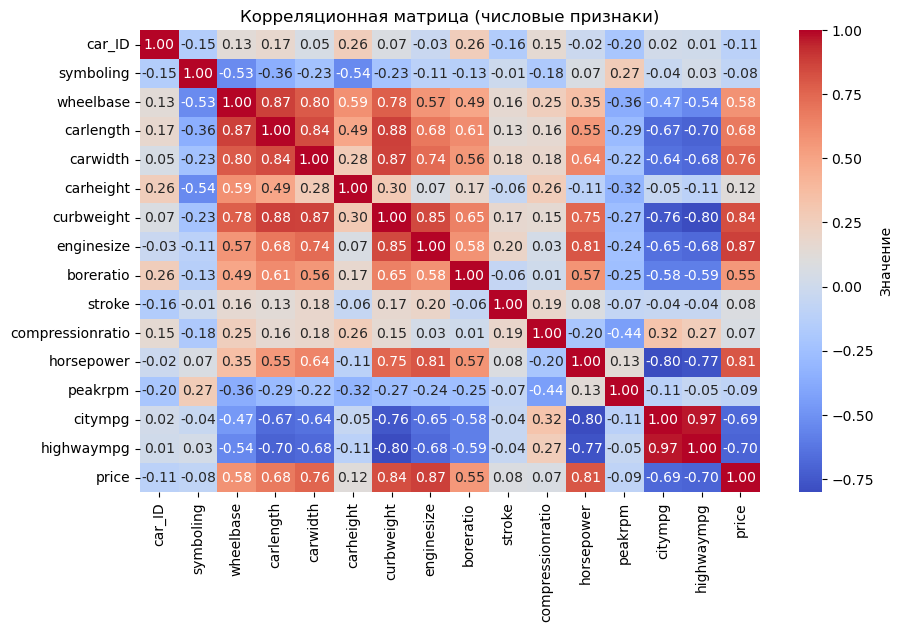

In [15]:
car.heatmap(correlation=True)

In [32]:
cat_car = car.correlation_category("price")
cat_car

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,price
CarName,1.000000,-0.069435,0.019914,-0.171745,0.099691,-0.016129,0.055968,-0.090381,0.047154,0.123845,-0.231439
fueltype,-0.069435,1.000000,-0.401397,0.191491,-0.147853,-0.132257,0.040070,0.082695,0.110617,0.041529,-0.105679
aspiration,0.019914,-0.401397,1.000000,-0.031792,0.063028,0.066465,-0.057191,-0.102963,-0.133119,0.288086,0.177926
doornumber,-0.171745,0.191491,-0.031792,1.000000,-0.680358,0.098954,0.137757,0.062431,0.154322,0.015519,-0.031835
carbody,0.099691,-0.147853,0.063028,-0.680358,1.000000,-0.155745,-0.277009,-0.037024,-0.048408,-0.065079,-0.083976
drivewheel,-0.016129,-0.132257,0.066465,0.098954,-0.155745,1.000000,0.147865,-0.116823,0.223238,0.424686,0.577992
enginelocation,0.055968,0.040070,-0.057191,0.137757,-0.277009,0.147865,1.000000,0.114127,0.135541,0.105971,0.324973
enginetype,-0.090381,0.082695,-0.102963,0.062431,-0.037024,-0.116823,0.114127,1.000000,0.237390,-0.091787,0.049171
cylindernumber,0.047154,0.110617,-0.133119,0.154322,-0.048408,0.223238,0.135541,0.237390,1.000000,0.011970,-0.027628
fuelsystem,0.123845,0.041529,0.288086,0.015519,-0.065079,0.424686,0.105971,-0.091787,0.011970,1.000000,0.526823


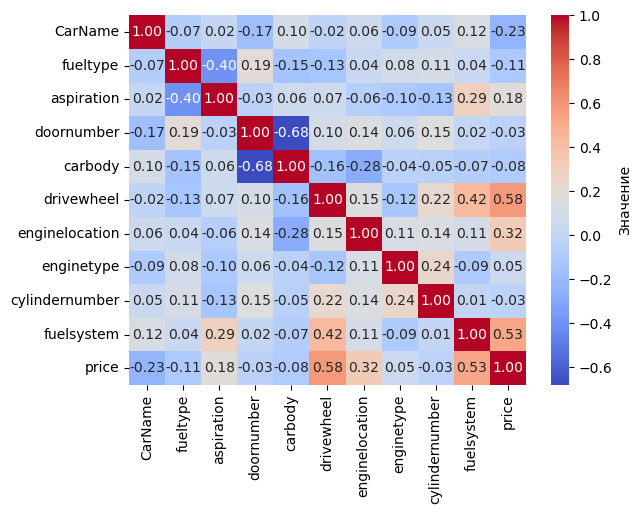

In [20]:
sns.heatmap(cat_car, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Значение'})
plt.show()

## Попробуе вычислить Mutual Information

In [33]:
# Целевая переменная
y = car.df['price']

# Кодируем категориальные переменные (Label Encoding)
categorical_columns = car.df.select_dtypes(include=['object']).columns
df_encoded = car.df.copy()

for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Убираем целевую переменную из X
X = df_encoded.drop(columns=['price'])

In [34]:
# Вычисляем MI
mi_scores = mutual_info_regression(X, y)

# Оформляем результат в DataFrame
mi_scores = pd.Series(mi_scores, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Выводим топ-10 признаков
print(mi_scores)

highwaympg          0.866897
curbweight          0.860433
horsepower          0.849041
enginesize          0.836057
citympg             0.728718
carwidth            0.665680
wheelbase           0.580001
carlength           0.557729
fuelsystem          0.466410
boreratio           0.447099
car_ID              0.439454
stroke              0.363237
carheight           0.339752
drivewheel          0.332726
cylindernumber      0.329050
CarName             0.269536
symboling           0.216136
peakrpm             0.203987
enginetype          0.164185
compressionratio    0.163452
aspiration          0.097139
fueltype            0.035909
carbody             0.033039
enginelocation      0.003587
doornumber          0.000000
dtype: float64


Исключение неинформативных признаков
doornumber (0.000000) → полностью бесполезен, удаляем.
enginelocation (0.003587) → очень слабая связь с ценой, можно удалить.
fueltype (0.035909) → низкий MI, можно удалить, 
carbody (0.051613) → можно удалить (слабая связь).
aspiration (0.096986) → слабая связь

Оставим только признаки с MI > 0.1, остальные удалить.

### wheelbase, carlength, carwidth, это размерные характеристики машины, которые логично связаны между собой. Они влияют на цену, но могут быть скоррелированы.

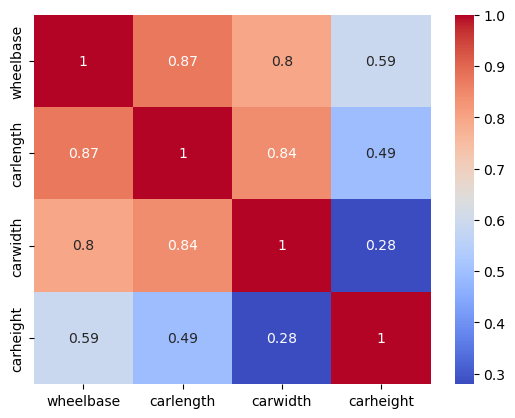

In [36]:
corr_matrix = df_encoded[['wheelbase', 'carlength', 'carwidth', 'carheight']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

### Полученная корреляция довольно высока(для всех кроме carheight), поэтому объединим остальные в одну фичу чтобы не растягивать веса и плохо влиять на важность

In [28]:
pca = PCA(n_components=1)
df_encoded['size_feature'] = pca.fit_transform(df_encoded[['wheelbase', 'carlength', 'carwidth']])

# Удаляем исходные столбцы
df_encoded.drop(columns=['wheelbase', 'carlength', 'carwidth'], inplace=True)

### Итоговый вывод по данным:
Так как целевой столбец у нас регрессионный, допустимо удалять признаки с низкой корреляцией (по числовым данным).
В нашем случае это:
car_ID (он просто не имеет смысла для модели), symboling, carheight, stroke, compressionratio, peakrpm.
По результатам анализa MI и корреляции категориальных признаков удаляем:
doornumber, enginelocation, fueltype, carbody, aspiration.
Так как признаки wheelbase, carlength, carwidth имеют высокую корреляцию (>0.8), вместо них создаём новый признак size_feature через PCA.

## Подготовка данных к моделированию

In [37]:
# Удаляем столбцы которые мы определили как ненужные
df_encoded.drop(columns=['car_ID', 'symboling', 'carheight', 'stroke', 'compressionratio', 'peakrpm'], inplace=True)
df_encoded.drop(columns=['doornumber', 'enginelocation', 'fueltype', 'carbody', 'aspiration'], inplace=True)

In [38]:
df_encoded

,CarName,drivewheel,wheelbase,carlength,carwidth,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,horsepower,citympg,highwaympg,price
0,2,2,88.6,168.8,64.1,2548,0,2,130,5,3.47,111,21,27,13495.0
1,3,2,88.6,168.8,64.1,2548,0,2,130,5,3.47,111,21,27,16500.0
2,1,2,94.5,171.2,65.5,2823,5,3,152,5,2.68,154,19,26,16500.0
3,4,1,99.8,176.6,66.2,2337,3,2,109,5,3.19,102,24,30,13950.0
4,5,0,99.4,176.6,66.4,2824,3,1,136,5,3.19,115,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,139,2,109.1,188.8,68.9,2952,3,2,141,5,3.78,114,23,28,16845.0
201,138,2,109.1,188.8,68.8,3049,3,2,141,5,3.78,160,19,25,19045.0
202,140,2,109.1,188.8,68.9,3012,5,3,173,5,3.58,134,18,23,21485.0
203,142,2,109.1,188.8,68.9,3217,3,3,145,3,3.01,106,26,27,22470.0


In [41]:
X = df_encoded.drop(columns=['price'])  
y = df_encoded['price'] 

In [49]:
# Разбиваем данные на тестовые и валидационные
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  random_state=42)


In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.to_numpy().reshape(-1, 1)).flatten()


## Снчала сделаем модель на Pytorch

In [53]:
# Конвертируем в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)  # Добавляем размерность

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)  # Добавляем размерность

In [54]:
# Создаём Dataset
class CarDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

# Создаём датасеты
train_dataset = CarDataset(X_train_tensor, y_train_tensor)
val_dataset = CarDataset(X_val_tensor, y_val_tensor)  


In [55]:
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [56]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size=128, hidden_size2=64, num_classes=1):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)  # Нормализация первого слоя
        self.relu = nn.LeakyReLU()

        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size2)  # Нормализация второго слоя
        self.leakrelu = nn.LeakyReLU()

        self.fc3 = nn.Linear(hidden_size2, num_classes)  # Для регрессии

    def forward(self, x):
        out = self.fc1(x)
        out = self.batchnorm1(out)  # Нормализация перед активацией
        out = self.relu(out)

        out = self.fc2(out)
        out = self.batchnorm2(out)  # Нормализация перед активацией
        out = self.leakrelu(out)

        out = self.fc3(out)  # Выход без активации (регрессия)
        return out

In [57]:
# Параметры обучения
num_epochs = 200

# Директория для сохранения моделей
os.makedirs("models/car", exist_ok=True)

# Определение функций потерь и оптимизаторов
loss_functions = {
    "MSE": nn.MSELoss(),
    "Huber": nn.HuberLoss()
}

optimizers = {
    "SGD": lambda model: optim.SGD(model.parameters(), lr=0.01),  
    "Adam": lambda model: optim.Adam(model.parameters(), lr=0.001),
    "RMSprop": lambda model: optim.RMSprop(model.parameters(), lr=0.001),
    "Adagrad": lambda model: optim.Adagrad(model.parameters(), lr=0.01)  
}

# Доступные устройства
devices = {
    "CPU": torch.device("cpu"),
    "GPU": torch.device("cuda") if torch.cuda.is_available() else None
}

# Словарь для хранения результатов
results = []

# Перебираем все комбинации
for loss_name, criterion in loss_functions.items():
    for opt_name, opt_func in optimizers.items():
        for device_name, device in devices.items():
            if device is None:  # Пропускаем GPU, если его нет
                continue

            print(f"\n🔍 Тестируем: {loss_name} + {opt_name} на {device_name}")

            # Инициализируем модель
            model = NeuralNet(input_size=X_train_tensor.shape[1]).to(device)

            # Создаём оптимизатор
            optimizer = opt_func(model)

            # Запускаем таймер
            start_time = time.time()

            best_train_loss = float("inf")  # Лучший результат на train loss
            best_model_path = f"models/car/{loss_name}_{opt_name}_{device_name}.pth"

            # Списки для хранения потерь
            train_losses = []

            # Early Stopping
            patience = 5  # Количество эпох без улучшений
            counter = 0  # Счётчик эпох без улучшения

            # Обучение модели
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0

                for X_batch, y_batch in train_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                avg_train_loss = running_loss / len(train_loader)
                train_losses.append(avg_train_loss)

                print(f"Эпоха {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}")

                # Проверяем early stopping на train loss
                if avg_train_loss < best_train_loss:
                    best_train_loss = avg_train_loss
                    counter = 0  # Сбрасываем счётчик
                    torch.save(model.state_dict(), best_model_path)  # Сохраняем лучшую модель
                    print(f"🎯 Новая лучшая модель сохранена: {best_model_path} (Train Loss: {avg_train_loss:.4f})")
                else:
                    counter += 1
                    print(f"Patience {counter}/{patience}")

                    if counter >= patience:
                        print("⏹️ Early stopping: train loss не улучшается!")
                        break  # Останавливаем обучение

            # Останавливаем таймер
            end_time = time.time()
            training_time = end_time - start_time

            # Сохраняем результаты
            results.append({
                "loss": loss_name,
                "optimizer": opt_name,
                "device": device_name,
                "best_train_loss": best_train_loss,
                "training_time": training_time,
                "model_path": best_model_path,
                "train_losses": train_losses
            })

            print(f"✅ Завершено: {loss_name} + {opt_name} на {device_name} | Best Train Loss: {best_train_loss:.4f} | Time: {training_time:.2f} сек")

# Выводим все результаты
print("\n📊 Итоговые результаты:")
for res in results:
    print(f"{res['loss']} + {res['optimizer']} на {res['device']} | Best Train Loss: {res['best_train_loss']:.4f} | Time: {res['training_time']:.2f} сек | Модель: {res['model_path']}")


🔍 Тестируем: MSE + SGD на CPU
Эпоха 1/200 | Train Loss: 1.3461
🎯 Новая лучшая модель сохранена: models/car/MSE_SGD_CPU.pth (Train Loss: 1.3461)
Эпоха 2/200 | Train Loss: 0.6050
🎯 Новая лучшая модель сохранена: models/car/MSE_SGD_CPU.pth (Train Loss: 0.6050)
Эпоха 3/200 | Train Loss: 0.3359
🎯 Новая лучшая модель сохранена: models/car/MSE_SGD_CPU.pth (Train Loss: 0.3359)
Эпоха 4/200 | Train Loss: 0.3151
🎯 Новая лучшая модель сохранена: models/car/MSE_SGD_CPU.pth (Train Loss: 0.3151)
Эпоха 5/200 | Train Loss: 0.1964
🎯 Новая лучшая модель сохранена: models/car/MSE_SGD_CPU.pth (Train Loss: 0.1964)
Эпоха 6/200 | Train Loss: 0.1902
🎯 Новая лучшая модель сохранена: models/car/MSE_SGD_CPU.pth (Train Loss: 0.1902)
Эпоха 7/200 | Train Loss: 0.1687
🎯 Новая лучшая модель сохранена: models/car/MSE_SGD_CPU.pth (Train Loss: 0.1687)
Эпоха 8/200 | Train Loss: 0.1503
🎯 Новая лучшая модель сохранена: models/car/MSE_SGD_CPU.pth (Train Loss: 0.1503)
Эпоха 9/200 | Train Loss: 0.1368
🎯 Новая лучшая модель со

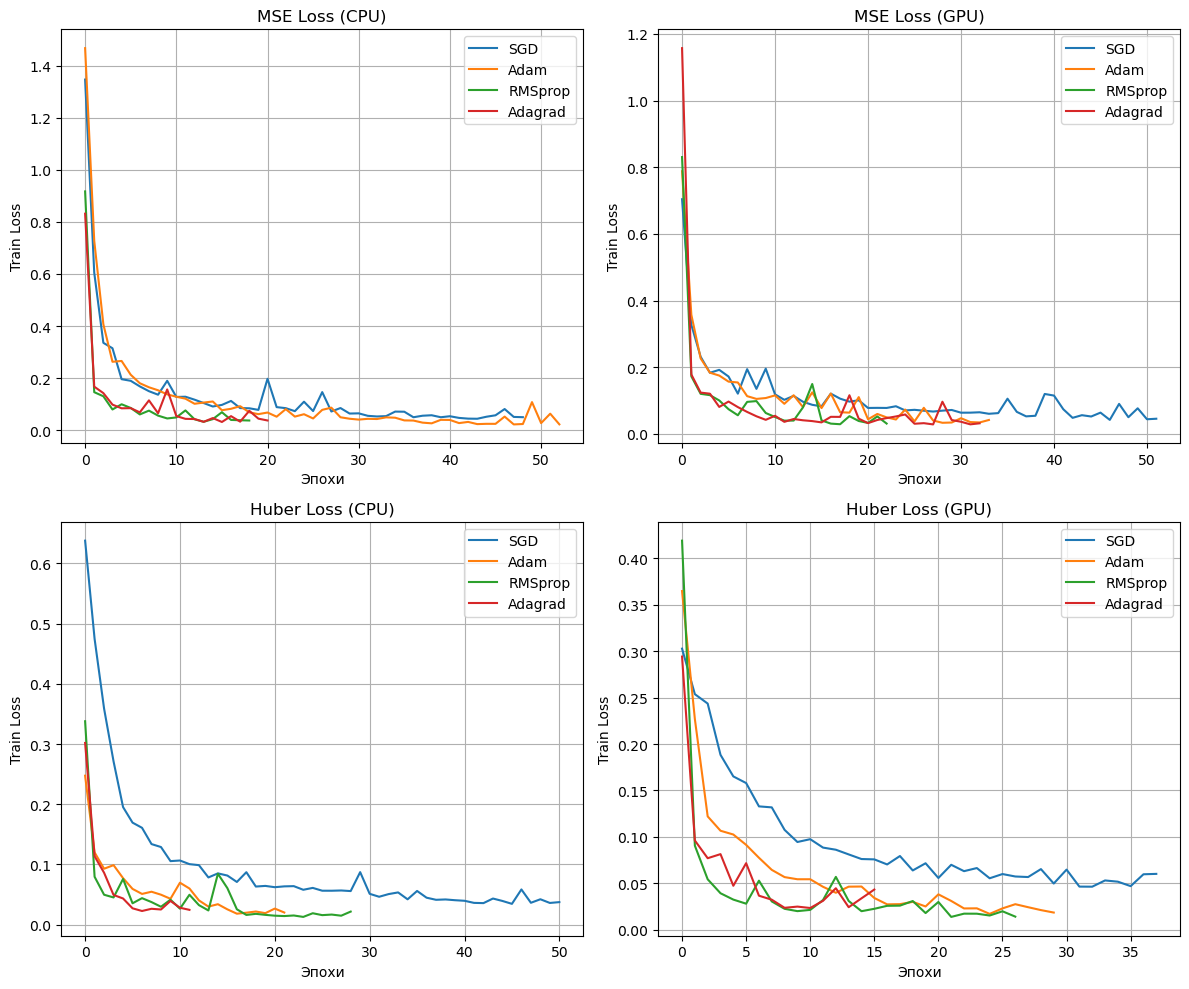

In [60]:
# Фильтруем результаты
mse_cpu = [res for res in results if res["loss"] == "MSE" and res["device"] == "CPU"]
mse_gpu = [res for res in results if res["loss"] == "MSE" and res["device"] == "GPU"]
huber_cpu = [res for res in results if res["loss"] == "Huber" and res["device"] == "CPU"]
huber_gpu = [res for res in results if res["loss"] == "Huber" and res["device"] == "GPU"]

# Функция для построения графика
def plot_losses(ax, results, title):
    for res in results:
        ax.plot(res["train_losses"], label=f"{res['optimizer']}")

    ax.set_xlabel("Эпохи")
    ax.set_ylabel("Train Loss")
    ax.set_title(title)
    ax.legend()
    ax.grid()

# Создаём 2x2 графики
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_losses(axes[0, 0], mse_cpu, "MSE Loss (CPU)")
plot_losses(axes[0, 1], mse_gpu, "MSE Loss (GPU)")
plot_losses(axes[1, 0], huber_cpu, "Huber Loss (CPU)")
plot_losses(axes[1, 1], huber_gpu, "Huber Loss (GPU)")

plt.tight_layout()
plt.show()

### Выводы: Лучшие результаты (наименьшая ошибка):

Huber + RMSprop на CPU (0.0126)
Huber + RMSprop на GPU (0.0137)
Huber + Adam на GPU (0.0170)
Это означает, что Huber Loss работает лучше, чем MSE, а среди оптимизаторов RMSprop показывает наилучшие результаты.

Разница CPU vs GPU:

В MSE + SGD на GPU выигрывает (0.0422 против 0.0446 на CPU).
В Huber + Adam GPU снова лучше (0.0170 против 0.0180).
Но в Huber + RMSprop CPU немного лучше (0.0126 против 0.0137).
Это может указывать на то, что для небольших сетей CPU может быть эффективнее для RMSprop, так как обработка малых батчей иногда быстрее на CPU из-за накладных расходов на передачу данных в GPU.

Скорость обучения:

Adam и RMSprop на CPU быстрее, чем на GPU.
GPU показывает выигрыш по скорости только в Adagrad и MSE с SGD.
Скорее все потом, что  GPU  на маленьких моделях тратит больше времени на инициализацию чем на работу.

Вывод: Предикты по всем моделям мы делать не будем. Мы обучим новую мождель на Huber + RMSprop с разнымии параметрами. 

In [61]:
# Параметры обучения
num_epochs = 200

# Директория для сохранения моделей
os.makedirs("models/car", exist_ok=True)

# Определение функций потерь и оптимизаторов
loss_functions = {
    "Huber": nn.HuberLoss()
}

# Оптимизаторы (разные параметры RMSprop)
optimizers = {
    "RMSprop_alpha_0.9_momentum_0.0": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.0, alpha=0.9),
    "RMSprop_alpha_0.99_momentum_0.0": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.0, alpha=0.99),
    "RMSprop_alpha_0.9_momentum_0.9": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9, alpha=0.9),
    "RMSprop_alpha_0.99_momentum_0.9": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9, alpha=0.99),
    "RMSprop_alpha_0.9_momentum_0.0_lr_0.01": lambda model: optim.RMSprop(model.parameters(), lr=0.01, momentum=0.0, alpha=0.9),
    "RMSprop_alpha_0.99_momentum_0.0_lr_0.01": lambda model: optim.RMSprop(model.parameters(), lr=0.01, momentum=0.0, alpha=0.99),
    "RMSprop_alpha_0.9_momentum_0.9_lr_0.01": lambda model: optim.RMSprop(model.parameters(), lr=0.01, momentum=0.9, alpha=0.9),
    "RMSprop_alpha_0.99_momentum_0.9_lr_0.01": lambda model: optim.RMSprop(model.parameters(), lr=0.01, momentum=0.9, alpha=0.99),
    "RMSprop_alpha_0.9_momentum_0.5": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.5, alpha=0.9),
    "RMSprop_alpha_0.9_momentum_0.7": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.7, alpha=0.9),
    "RMSprop_alpha_0.9_momentum_0.3": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.3, alpha=0.9),
    "RMSprop_alpha_0.8_momentum_0.5": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.7, alpha=0.8),
    "RMSprop_alpha_0.85_momentum_0.7": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.7, alpha=0.85),
    "RMSprop_alpha_0.9_momentum_0.7_lr_0.0005": lambda model: optim.RMSprop(model.parameters(), lr=0.0005, momentum=0.7, alpha=0.9),
}

# Доступные устройства
devices = {
    "CPU": torch.device("cpu"),
    # "GPU": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
}

# Словарь для хранения результатов
results = []

# Перебираем все комбинации
for loss_name, criterion in loss_functions.items():
    for opt_name, opt_func in optimizers.items():
        for device_name, device in devices.items():
            if device is None:  # Пропускаем GPU, если его нет
                continue

            print(f"\n🔍 Тестируем: {loss_name} + {opt_name} на {device_name}")

            # Инициализируем модель
            model = NeuralNet(input_size=X_train_tensor.shape[1]).to(device)

            # Создаём оптимизатор
            optimizer = opt_func(model)

            # Запускаем таймер
            start_time = time.time()

            best_train_loss = float("inf")  # Лучший результат на train loss
            best_model_path = f"models/car/{loss_name}_{opt_name}_{device_name}.pth"

            # Списки для хранения потерь
            train_losses = []

            # Early Stopping
            patience = 5  # Количество эпох без улучшений
            counter = 0  # Счётчик эпох без улучшения

            # Обучение модели
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0

                for X_batch, y_batch in train_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                avg_train_loss = running_loss / len(train_loader)
                train_losses.append(avg_train_loss)

                print(f"Эпоха {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}")

                # Проверяем early stopping на train loss
                if avg_train_loss < best_train_loss:
                    best_train_loss = avg_train_loss
                    counter = 0  # Сбрасываем счётчик
                    torch.save(model.state_dict(), best_model_path)  # Сохраняем лучшую модель
                    print(f"🎯 Новая лучшая модель сохранена: {best_model_path} (Train Loss: {avg_train_loss:.4f})")
                else:
                    counter += 1
                    print(f"Patience {counter}/{patience}")

                    if counter >= patience:
                        print("⏹️ Early stopping: train loss не улучшается!")
                        break  # Останавливаем обучение

            # Останавливаем таймер
            end_time = time.time()
            training_time = end_time - start_time

            # Сохраняем результаты
            results.append({
                "loss": loss_name,
                "optimizer": opt_name,
                "device": device_name,
                "best_train_loss": best_train_loss,
                "training_time": training_time,
                "model_path": best_model_path,
                "train_losses": train_losses
            })

            print(f"✅ Завершено: {loss_name} + {opt_name} на {device_name} | Best Train Loss: {best_train_loss:.4f} | Time: {training_time:.2f} сек")

# Выводим все результаты
print("\n📊 Итоговые результаты:")
for res in results:
    print(f"{res['loss']} + {res['optimizer']} на {res['device']} | Best Train Loss: {res['best_train_loss']:.4f} | Time: {res['training_time']:.2f} сек | Модель: {res['model_path']}")


🔍 Тестируем: Huber + RMSprop_alpha_0.9_momentum_0.0 на CPU
Эпоха 1/200 | Train Loss: 0.3955
🎯 Новая лучшая модель сохранена: models/car/Huber_RMSprop_alpha_0.9_momentum_0.0_CPU.pth (Train Loss: 0.3955)
Эпоха 2/200 | Train Loss: 0.1042
🎯 Новая лучшая модель сохранена: models/car/Huber_RMSprop_alpha_0.9_momentum_0.0_CPU.pth (Train Loss: 0.1042)
Эпоха 3/200 | Train Loss: 0.0730
🎯 Новая лучшая модель сохранена: models/car/Huber_RMSprop_alpha_0.9_momentum_0.0_CPU.pth (Train Loss: 0.0730)
Эпоха 4/200 | Train Loss: 0.0814
Patience 1/5
Эпоха 5/200 | Train Loss: 0.0663
🎯 Новая лучшая модель сохранена: models/car/Huber_RMSprop_alpha_0.9_momentum_0.0_CPU.pth (Train Loss: 0.0663)
Эпоха 6/200 | Train Loss: 0.0489
🎯 Новая лучшая модель сохранена: models/car/Huber_RMSprop_alpha_0.9_momentum_0.0_CPU.pth (Train Loss: 0.0489)
Эпоха 7/200 | Train Loss: 0.0630
Patience 1/5
Эпоха 8/200 | Train Loss: 0.0410
🎯 Новая лучшая модель сохранена: models/car/Huber_RMSprop_alpha_0.9_momentum_0.0_CPU.pth (Train Loss

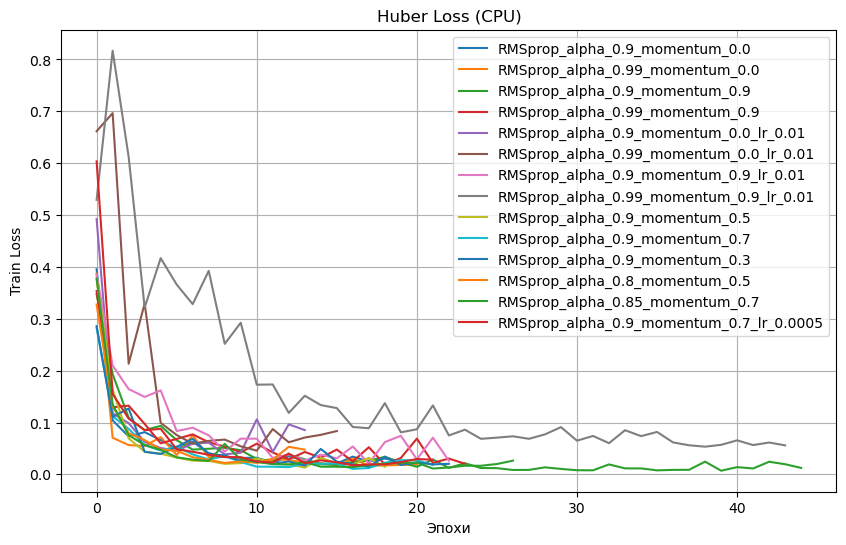

In [68]:
# Фильтруем результаты
huber_cpu = [res for res in results if res["loss"] == "Huber" and res["device"] == "CPU"]

# Строим один график
plt.figure(figsize=(10, 6))
for res in huber_cpu:
    plt.plot(res["train_losses"], label=f"{res['optimizer']}")

plt.xlabel("Эпохи")
plt.ylabel("Train Loss")
plt.title("Huber Loss (CPU)")
plt.legend()
plt.grid()
plt.show()

Лучший результат по Best Train Loss показала модель с Huber Loss + RMSprop(alpha=0.9, momentum=0.9):
Loss: 0.0070
Time: 0.36 сек

Выводы:

Меньший lr (0.001) + высокий momentum (0.9) дали лучший результат.
Увеличение alpha до 0.99 ухудшило Loss в большинстве случаев.
Увеличение lr до 0.01 привело к росту Loss (чрезмерное обновление весов).
Оптимальный баланс: alpha=0.9, momentum=0.9, lr=0.001.


In [72]:
# Загружаем лучшую модель
best_model_path = "models/car/Huber_RMSprop_alpha_0.9_momentum_0.9_CPU.pth"  # путь к лучшей модели
model = NeuralNet(input_size=X_train_tensor.shape[1])
model.load_state_dict(torch.load(best_model_path, map_location=torch.device("cpu"), weights_only=True))

model.eval()  # Переводим в режим инференса

# Загружаем тестовые данные и нормализуем их
X_test_scaled = X_val_scaled  # Используем валидацию как тест
X_test_tensor = X_val_tensor  # Используем тот же тензор

# Делаем предсказания
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()

# Денормализуем предсказания
y_pred = scaler_y.inverse_transform(y_pred_scaled)

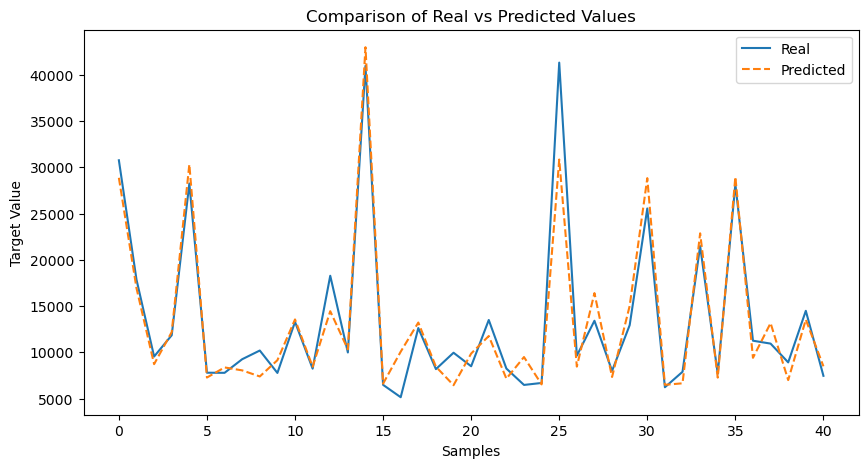

In [74]:
# Визуализация предсказаний vs реальные значения
plt.figure(figsize=(10, 5))
plt.plot(y_val.to_numpy(), label="Real")
plt.plot(y_pred, label="Predicted", linestyle="dashed")
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Comparison of Real vs Predicted Values")
plt.legend()
plt.show()

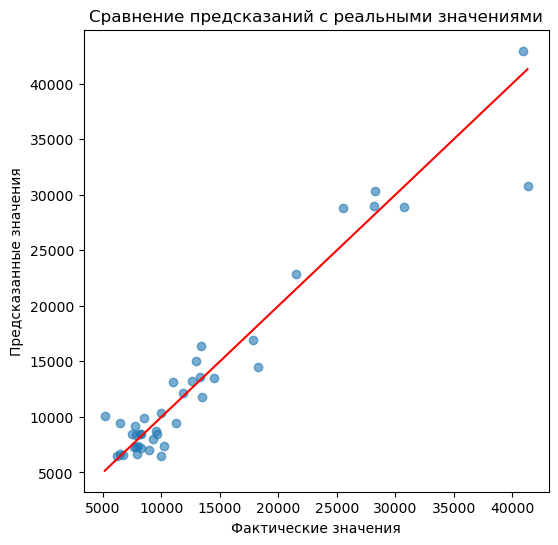

In [75]:
# Построим scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')  # Линия идеального предсказания
plt.show()

### Рассчитаем точностные характеристики

In [82]:
r2 = r2_score(y_val, y_pred)
print(f"R² score: {r2:.4f}")


mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)  # Корень из MSE

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


y_val_1d = y_val.to_numpy().flatten()  # Преобразуем в 1D-массив
y_pred_1d = y_pred.flatten()  # Убираем лишнюю ось, если есть

mape = np.mean(np.abs((y_val_1d - y_pred_1d) / y_val_1d)) * 100
print(f"MAPE: {mape:.2f}%")


R² score: 0.9239
MAE: 1675.0711
MSE: 6007004.9115
RMSE: 2450.9192
MAPE: 14.10%


/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R² score (коэффициент детерминации) - 0.9239
- 92.39% дисперсии в данных объясняется моделью. Чем ближе к 1, тем лучше.
MAE (Mean Absolute Error) - 1675.07
- Средняя абсолютная ошибка - 1675 единиц.
MSE (Mean Squared Error) - 6,007,004
- Квадрат среднеквадратичной ошибки. Чем меньше, тем лучше.
RMSE (Root Mean Squared Error) - 2450.92
- Сильнее штрафует большие ошибки по сравнению с MAE.
MAPE (Mean Absolute Percentage Error) - 14.10%
- Средний процент ошибки составляет 14.1%.


## Попробуем стэкинг на топ-3 из общих моделей (где мы подбирали функцию потерь и оптимизатор)
Судя по Best Train Loss это:

Huber + RMSprop на CPU → 0.0126
Huber + Adam на GPU → 0.0170
MSE + Adam на CPU → 0.0229


In [86]:
# Функция для загрузки модели и предсказаний
def get_predictions(model_path, X_tensor):
    model = NeuralNet(input_size=X_tensor.shape[1])
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu"), weights_only=True))
    model.eval()
    with torch.no_grad():
        return model(X_tensor).numpy()

# Загружаем предсказания 3-х моделей
y_pred_1 = get_predictions("models/car/Huber_RMSprop_CPU.pth", X_val_tensor)
y_pred_2 = get_predictions("models/car/Huber_Adam_GPU.pth", X_val_tensor)
y_pred_3 = get_predictions("models/car/MSE_Adam_CPU.pth", X_val_tensor)

# Создаём новый датасет для мета-модели
X_meta = np.column_stack([y_pred_1, y_pred_2, y_pred_3])
y_meta = y_val  # Истинные значения

# Обучаем простую линейную регрессию как мета-модель
meta_model = LinearRegression()
meta_model.fit(X_meta, y_meta)

# Делаем финальные предсказания
y_pred_final = meta_model.predict(X_meta)

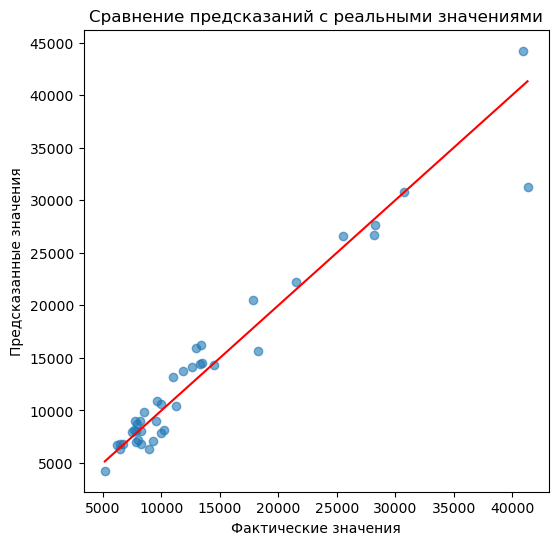

In [88]:
# Построим scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_final, alpha=0.6)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')  # Линия идеального предсказания
plt.show()

In [87]:

r2 = r2_score(y_meta, y_pred_final)
mae = mean_absolute_error(y_meta, y_pred_final)
rmse = mean_squared_error(y_meta, y_pred_final, squared=False)

print(f"Stacked R²: {r2:.4f}")
print(f"Stacked MAE: {mae:.2f}")
print(f"Stacked RMSE: {rmse:.2f}")


Stacked R²: 0.9400
Stacked MAE: 1449.26
Stacked RMSE: 2175.54


/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Вывод:  R² вырос до 0.94 → модель лучше объясняет дисперсию данных.
🔹 MAE и RMSE снизились → ошибки стали меньше, значит, предсказания стали точнее.
🔹 График подтверждает, что предсказания ближе к идеальной линии.

## Попробуем сделать еще одну метамодель (XGBoost) по топ-5 моделей
Топ-5 моделей из списка:

Huber + RMSprop на CPU - 0.0126
Huber + RMSprop на GPU - 0.0137
Huber + Adam на GPU - 0.0170
Huber + Adam на CPU - 0.0180
MSE + Adam на CPU - 0.0229

In [94]:
# Загружаем предсказания топ-5 моделей
model_paths = [
    "models/car/Huber_RMSprop_CPU.pth",
    "models/car/Huber_RMSprop_GPU.pth",
    "models/car/Huber_Adam_GPU.pth",
    "models/car/Huber_Adam_CPU.pth",
    "models/car/MSE_Adam_CPU.pth",
]

meta_features = []

for path in model_paths:
    model = NeuralNet(input_size=X_train_tensor.shape[1])
    model.load_state_dict(torch.load(path, map_location=torch.device("cpu"), weights_only=True))
    model.eval()
    
    with torch.no_grad():
        y_pred_scaled = model(X_val_tensor).numpy()
    
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    meta_features.append(y_pred.flatten())

# Формируем X_train_meta (размер [кол-во образцов, 5])
X_train_meta = np.column_stack(meta_features)

# Обучаем XGBoost на новых фичах
xgb_model = xgb.XGBRegressor(
    n_estimators=100,  # Ограничиваем число деревьев
    max_depth=4,       # Ограничиваем глубину деревьев
    learning_rate=0.1, # Чуть уменьшим шаг обучения
    subsample=0.8,     # Берём 80% данных в каждом дереве (регуляризация)
    colsample_bytree=0.8, # 80% фичей на каждое дерево
    random_state=42
)

xgb_model.fit(X_train_meta, y_val)
# Делаем предсказания
y_pred_xgb = xgb_model.predict(X_train_meta)


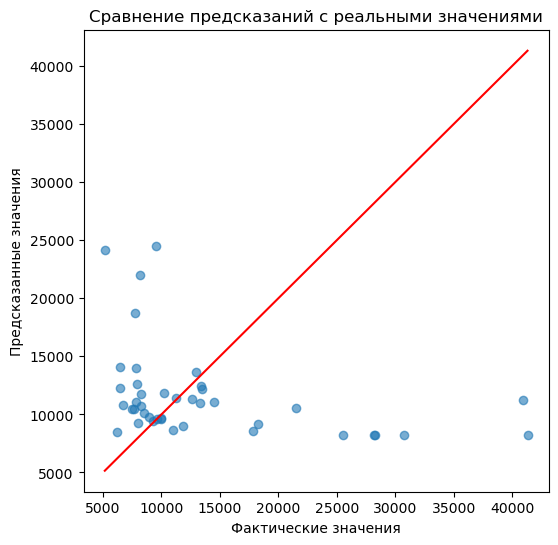

In [144]:
# Построим scatter plot

plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_xgb, alpha=0.6)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')  # Линия идеального предсказания
plt.show()

In [95]:
# Оценка модели
r2 = r2_score(y_val, y_pred_xgb)
mae = mean_absolute_error(y_val, y_pred_xgb)
rmse = mean_squared_error(y_val, y_pred_xgb, squared=False)
mape = np.mean(np.abs((y_val - y_pred_xgb) / y_val)) * 100

# Вывод результатов
print(f"XGBoost R²: {r2:.4f}")
print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost R²: 0.9998
XGBoost MAE: 91.35
XGBoost RMSE: 121.41
XGBoost MAPE: 0.89%


/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Несмотря на R²: 0.9998 - на графике данные слишко ращзбросаны. Т.е это явное переобучение.

## Теперь попробуем построить модели с помощью tensorflow

### Вначале используем данные оптимизатора и loss -лучшие полученные в pytorch

In [132]:
X_keras = df_encoded.drop(columns=['price'])  
y_keras = df_encoded['price'] 

In [133]:
# Разбиваем данные на тестовые и валидационные
X_train, X_val, y_train, y_val = train_test_split(X_keras, y_keras, test_size=0.2, 
                                                  random_state=42)


In [134]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.to_numpy().reshape(-1, 1)).flatten()

In [136]:
# Создаём модель

model_tensor = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Входной слой

    keras.layers.Dense(128),  
    keras.layers.BatchNormalization(),  # Нормализация перед LeakyReLU
    keras.layers.LeakyReLU(),  

    keras.layers.Dense(64),  
    keras.layers.BatchNormalization(),  # Нормализация перед LeakyReLU
    keras.layers.LeakyReLU(),  

    keras.layers.Dense(1)  # Выходной слой (без активации)
])

# Компиляция модели
model_tensor.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.9, rho=0.9), 
    loss=tf.keras.losses.Huber(), 
    metrics=['mse']
)


# Функции callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model_car.keras', monitor='val_loss', 
                    save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
]

# История обучения хранится в объекте history
history = model_tensor.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=64, 
                    validation_data=(X_val_scaled, y_val_scaled), 
                    callbacks=callbacks, verbose=1)

# Оценка на тесте
test_loss, test_mae = model_tensor.evaluate(
    X_val_scaled, y_val_scaled, verbose=1)
test_mae_real = test_mae * scaler_y.scale_[0]
print("\nMAE в реальных единицах:", test_mae_real)


Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.5066 - mse: 1.3373 - val_loss: 0.2006 - val_mse: 0.4638 - learning_rate: 0.0010
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2901 - mse: 0.6620 - val_loss: 0.1788 - val_mse: 0.4467 - learning_rate: 0.0010
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1931 - mse: 0.4173 - val_loss: 0.2230 - val_mse: 0.5711 - learning_rate: 0.0010
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1746 - mse: 0.3803 - val_loss: 0.1492 - val_mse: 0.3444 - learning_rate: 0.0010
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1242 - mse: 0.2542 - val_loss: 0.0929 - val_mse: 0.2013 - learning_rate: 0.0010
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0718 - mse: 0.1454 - val_loss: 0.1028 - val_mse: 0.2236 - learning_rate: 0.0010
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0821 - mse: 0.1647 - val_loss: 0.0812 - val_mse: 0.1709 - learning_rate: 0.0010
Epoch 8/200
3/3 ━━━

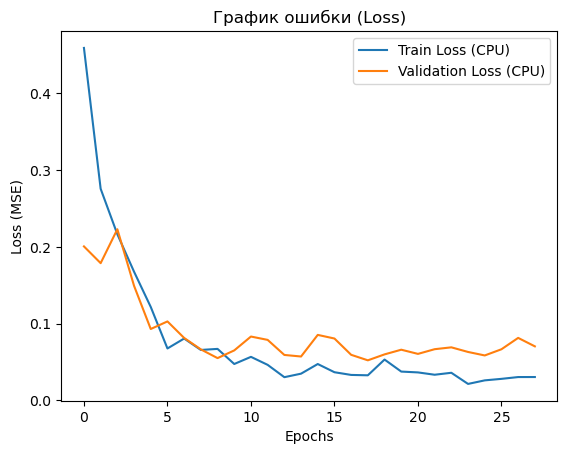

In [139]:
# График ошибки для CPU
plt.plot(history.history['loss'], label='Train Loss (CPU)')
plt.plot(history.history['val_loss'], label='Validation Loss (CPU)')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('График ошибки (Loss)')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


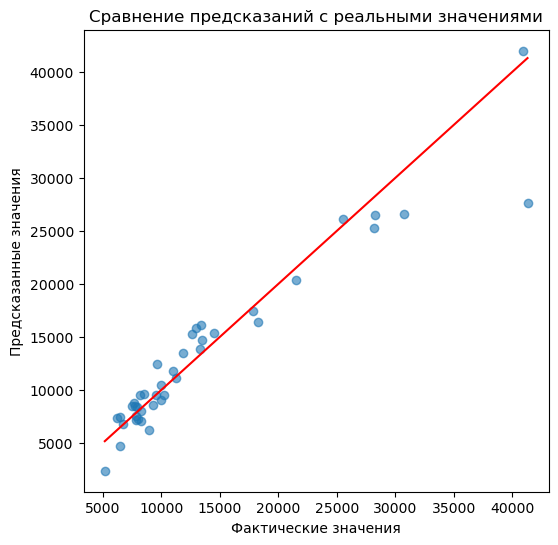

In [141]:
# Получаем предсказания
y_pred_scaled = model_tensor.predict(X_val_scaled)

# Обратно преобразуем предсказания в реальные значения
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Построим scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')

# Линия идеального предсказания
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')

plt.show()

In [142]:
r2 = r2_score(y_val, y_pred)
print(f"R² score: {r2:.4f}")


mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)  # Корень из MSE

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


y_val_1d = y_val.to_numpy().flatten()  # Преобразуем в 1D-массив
y_pred_1d = y_pred.flatten()  # Убираем лишнюю ось, если есть

mape = np.mean(np.abs((y_val_1d - y_pred_1d) / y_val_1d)) * 100
print(f"MAPE: {mape:.2f}%")

R² score: 0.9103
MAE: 1582.1248
MSE: 7078138.8972
RMSE: 2660.4772
MAPE: 12.29%


/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Вывод: Показатели довольно близкие и на графике данные распложены блико к линии.
Общие выводы такие:

PyTorch (до стекинга): R² = 0.9239, MAE = 1675.07
Стекинг (на PyTorch): R² = 0.9400, MAE = 1449.26
TensorFlow: R² = 0.9103, MAE = 1582.12

Стекинг улучшил результаты PyTorch:

R² увеличился с 0.9239 до 0.9400
MAE уменьшился с 1675.07 до 1449.26
RMSE тоже снизился - предсказания стали точнее
Это подтверждает, что стекинг помогает улучшить предсказания.
TensorFlow немного хуже, чем PyTorch:

R² = 0.9103 (хуже, чем 0.9239 у PyTorch)
MAE = 1582.12 (лучше, чем 1675 у PyTorch, но хуже, чем 1449 после стекинга)
RMSE выше, чем у стекинг-модели